#**Importing the required libraries**

In [1]:
import os
import re

import librosa
import librosa.display
!pip install --upgrade librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
from keras import layers
from keras import models
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import itertools

In [2]:
#Start by connecting gdrive into the google colab

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Paths for data.
Ravdess = "/content/gdrive/MyDrive/Audio Dataset/RAV/"

In [4]:
os.chdir('/content/gdrive/MyDrive/Audio Dataset')

**Ravdess dataset**

  Emotion:
  
      01 = neutral
      02 = calm
      03 = happy
      04 = sad
      05 = angry
      06 = fearful
      07 = disgust
      08 = surprised

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        if len(info) >= 3:  # Check if info contains at least 3 elements
            emotion = int(info[2])
            emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))


Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df

,Emotion,Path
0,fear,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
1,surprise,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
2,fear,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
3,sad,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
4,happy,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
...,...,...
1435,happy,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
1436,fear,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
1437,happy,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
1438,fear,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...


In [6]:
# creating Dataframe using all the 2 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.shape

(1440, 2)

In [7]:
data_path.head(10)

,Emotion,Path
0,fear,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
1,surprise,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
2,fear,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
3,sad,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
4,happy,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
5,disgust,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
6,angry,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
7,sad,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
8,surprise,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
9,surprise,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...


#**Data Visualisation and Exploration**
First let's plot the count of each emotions in our dataset.

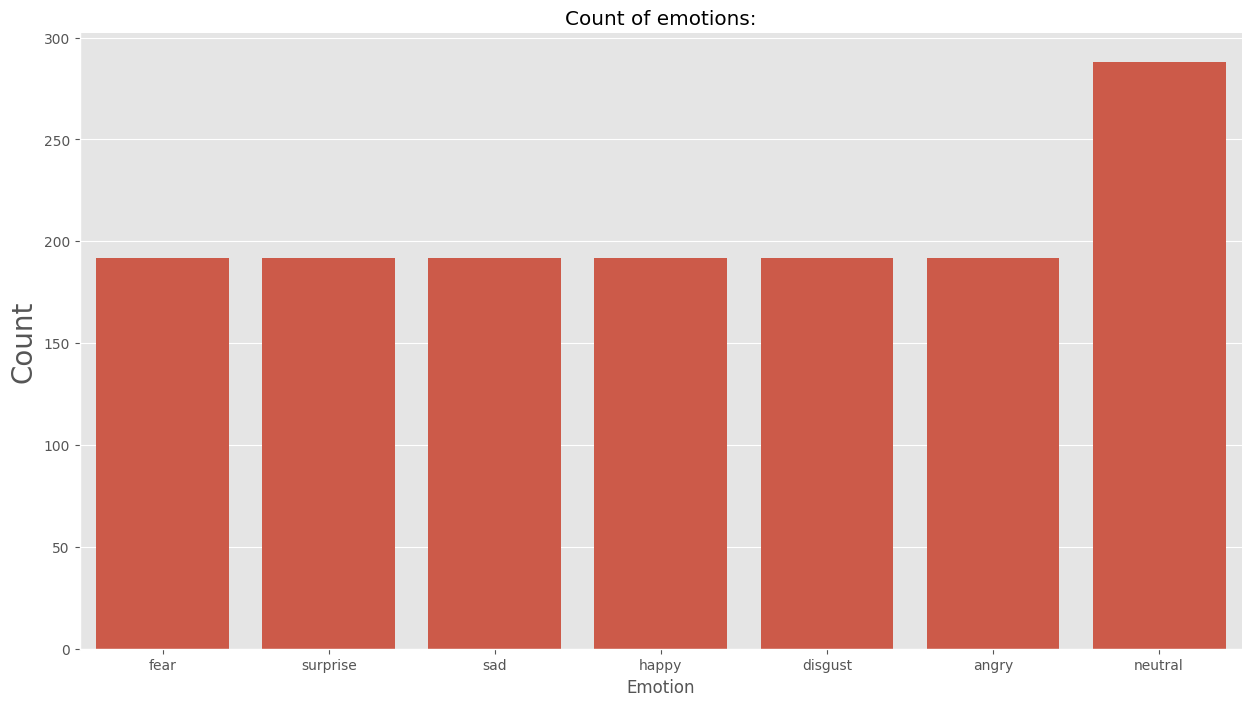

In [8]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,8)
plt.style.use("ggplot")
plt.ylabel('Count', size=20)
plt.title("Count of emotions:")
sns.countplot(x=data_path["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

#**We can also plot waveplots and spectograms for audio signals.**


*   Waveplots - Waveplots let us know the loudness of the audio at a given time.
*   Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.





In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

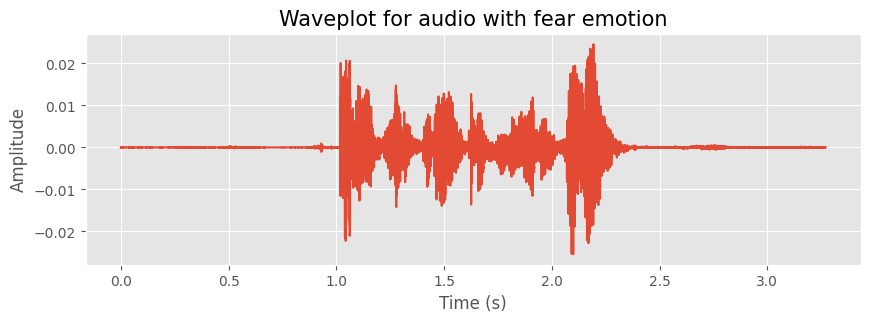

In [10]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    plt.plot(np.arange(len(data)) / sr, data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotion == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)


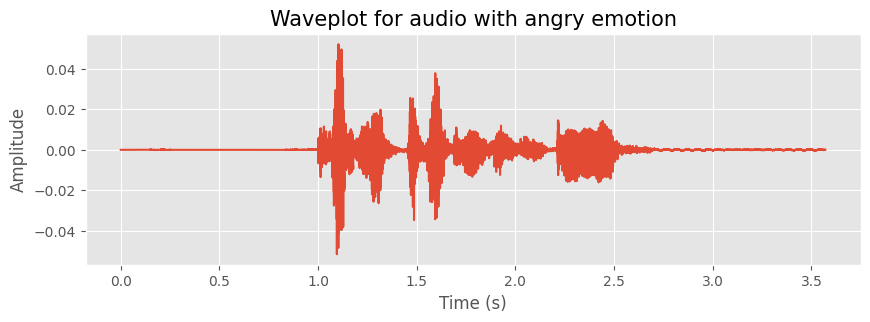

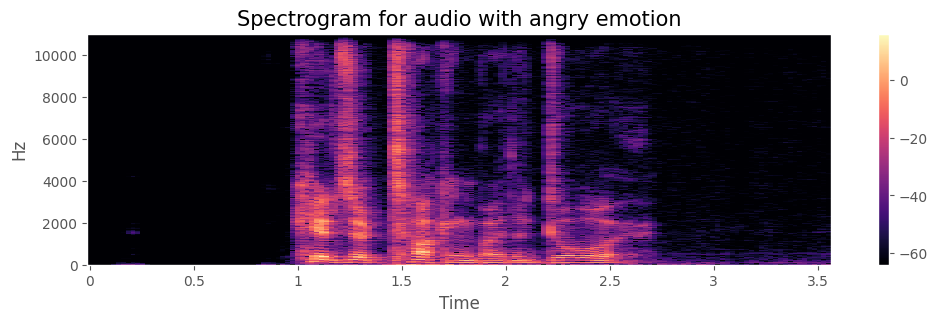

In [11]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

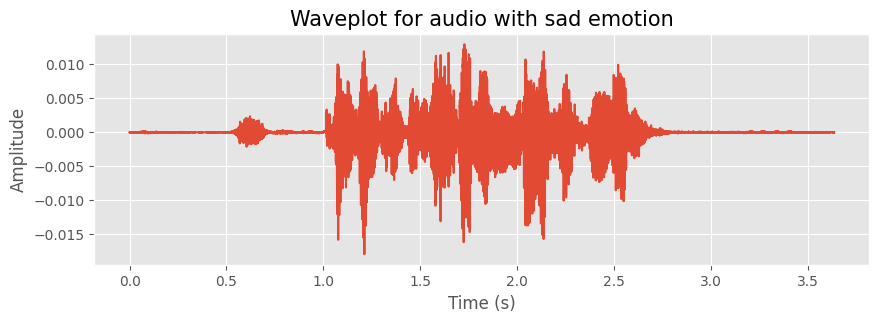

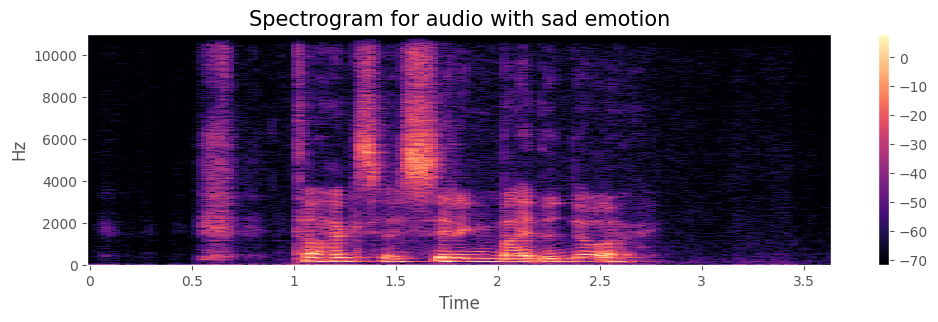

In [12]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#**Data Augmentation**


Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

**We have some ways for data augmentation in sound data:**

*   Noise injection

*   Stretching

*   Shifting

*   Pitching


In [13]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor = np.random.random() * pitch_factor
    n_steps = int(pitch_factor * len(data) / sampling_rate)
    pitched_data = librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)
    return pitched_data

In [14]:
data_path.head()

,Emotion,Path
0,fear,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
1,surprise,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
2,fear,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
3,sad,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...
4,happy,/content/gdrive/MyDrive/Audio Dataset/RAV/Acto...


In [15]:
path = data_path[data_path["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

**1. Simple Audio**

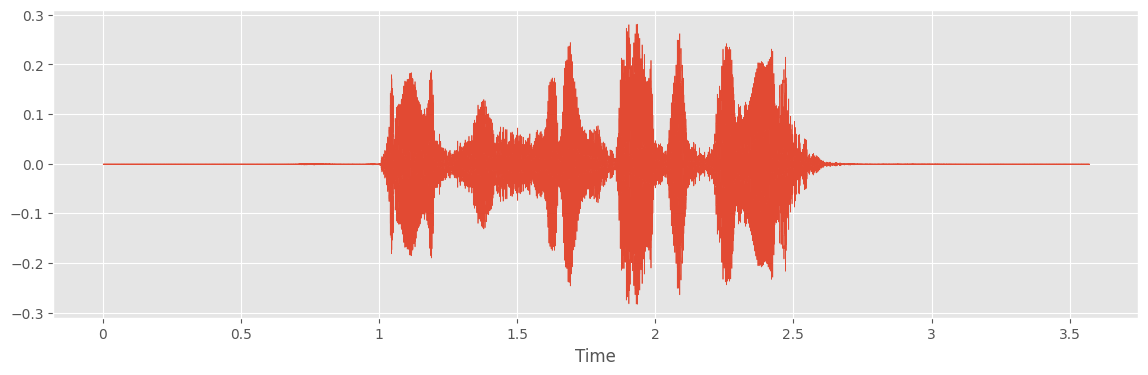

In [16]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data, sr=sampling_rate)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

**2. Noise Injection**

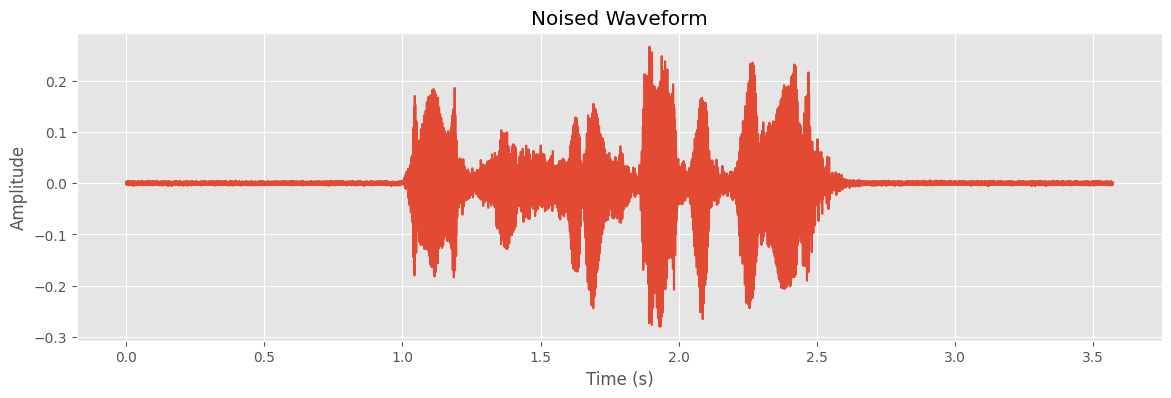

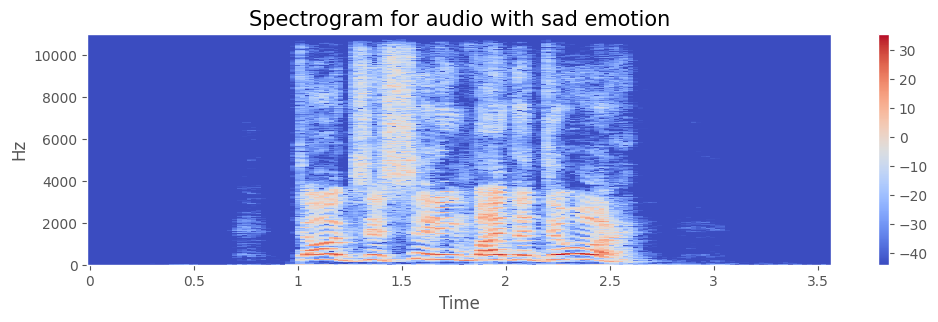

In [17]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
plt.plot(np.arange(len(noised_data)) / sampling_rate, noised_data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noised Waveform')
plt.show()
create_spectrogram(data, sampling_rate, emotion)
Audio(noised_data, rate=sampling_rate)

**3. Stretching**

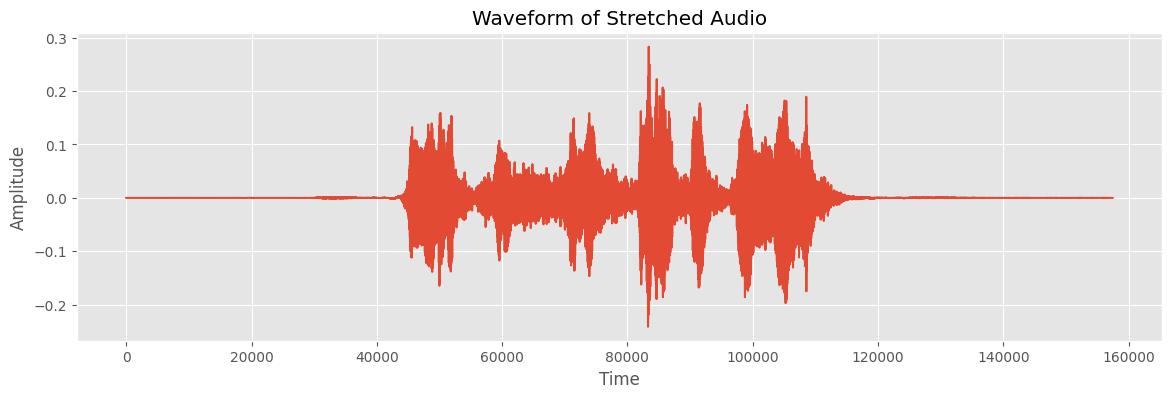

In [18]:
stretched_data = librosa.effects.time_stretch(data, rate=0.5)
plt.figure(figsize=(14, 4))
plt.plot(stretched_data)  # Plot the waveform
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform of Stretched Audio')
plt.show()
create_spectrogram(data, sampling_rate, emotion)
Audio(stretched_data, rate=sampling_rate)

**4. Shifting**

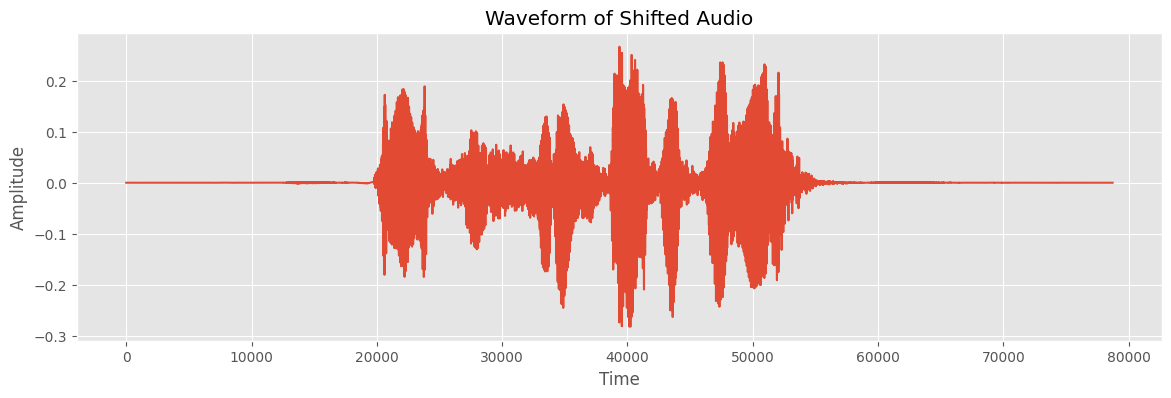

In [19]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
plt.plot(shifted_data)  # Plot the waveform
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform of Shifted Audio')
plt.show()
create_spectrogram(data, sampling_rate, emotion)
Audio(shifted_data, rate=sampling_rate)

**5. Pitch**

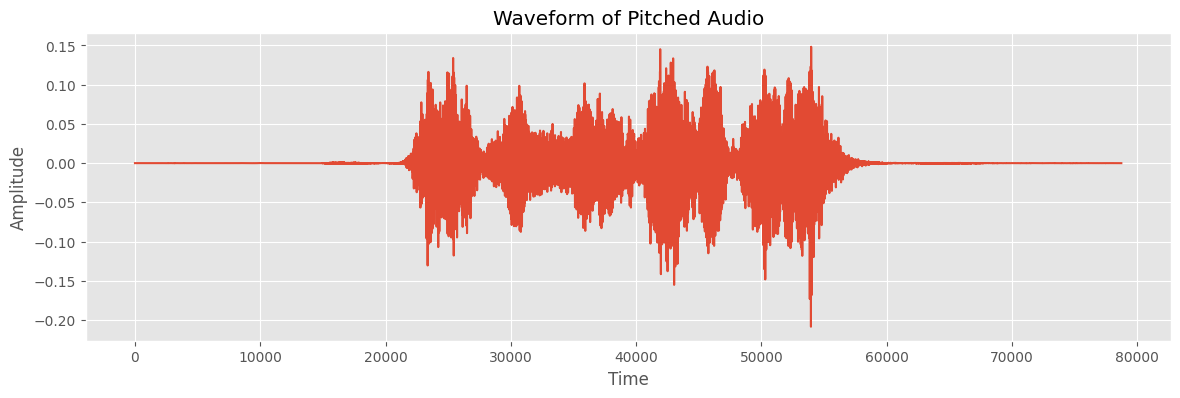

In [20]:
pitch_factor=0.5

pitched_data = librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)
plt.figure(figsize=(14,4))
plt.plot(pitched_data)  # Plot the waveform
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform of Pitched Audio')
plt.show()
create_spectrogram(data, sampling_rate, emotion)
Audio(pitched_data, rate=sampling_rate)

#**Feature Extraction**

Extraction of features is a very important part in analyzing and finding relations between different things.

As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

**There are some features may be useful:**

          Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.

          Energy : The sum of squares of the signal values, normalized by the respective frame length.

          Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.

          Spectral Centroid : The center of gravity of the spectrum.

          Spectral Spread : The second central moment of the spectrum.

          Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.

          Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.

          Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.

          MFCCs : Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [21]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

**Let's check data formats:**

In [22]:
path = np.array(data_path["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

55125

In [23]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (108,)
Energy:  (108,)
Entropy of Energy : (108,)
RMS : (108,)
Spectral Centroid : (108,)
Spectral Flux:  ()
Spectral Rollof:  (108,)
Chroma STFT:  (1296,)
MelSpectrogram:  (13824,)
MFCC:  (2160,)


**In experimental way was decided to use just 3 main features for this task: ZCR, RMS and MFCC.**

**Also in experimental way was decided to use just 2.5s duration with 0.6 offset - in the dataset first 0.6s contains no information about emotion, and most of them are less then 3s.**

In [24]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [25]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitch_factor = 0.5  # You can adjust this value as needed
    pitched_data = pitch(data, sample_rate, pitch_factor, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, pitch_factor, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res4 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res4)) # stacking vertically

    return result


In [26]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(data_path.Path, data_path.Emotion, range(data_path.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
Done.


**Let's save our features as DataFrame for further processing:**

In [27]:
features_path = "features.csv"
print (features_path)

features.csv


In [28]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.083008,0.098145,0.098145,0.083984,0.041016,0.034668,0.054199,0.048828,0.062988,0.134766,...,-18.092384,-5.094963,-2.514428,3.313077,7.063478,3.757756,-5.812872,-2.598984,4.525644,fear
1,0.198242,0.311035,0.418945,0.452148,0.470215,0.473145,0.491699,0.497070,0.495117,0.494141,...,-0.521066,-3.115645,2.909543,10.356937,5.014342,2.187804,-0.741408,-3.930141,-0.556358,fear
2,0.076660,0.091309,0.091309,0.060547,0.022949,0.017090,0.034668,0.053223,0.053223,0.082520,...,-23.003605,1.752240,2.208914,8.718785,10.063871,-0.334561,-7.567230,4.275956,-5.925833,fear
3,0.106445,0.142090,0.145996,0.166992,0.117676,0.169434,0.256348,0.297852,0.378906,0.404785,...,-16.037605,0.237645,4.454811,3.829860,5.231395,-1.547803,-5.525420,3.237959,-2.452387,fear
4,0.436035,0.618164,0.820801,0.774414,0.751465,0.751953,0.731934,0.668945,0.651367,0.676758,...,3.162414,2.357725,1.465563,0.524058,-0.392779,-1.194598,-1.798148,-2.147705,-2.228454,surprise


In [ ]:
# Define the file path
features_path = '/content/gdrive/MyDrive/Audio Dataset/features.csv'

# Save the DataFrame to CSV
extracted_df.to_csv(features_path, index=False)

# Display the first few rows of the DataFrame
extracted_df.head()

In [29]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(5760, 2377)


In [30]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(5760, 2377)

In [31]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.083008,0.098145,0.098145,0.083984,0.041016,0.034668,0.054199,0.048828,0.062988,0.134766,...,-18.092384,-5.094963,-2.514428,3.313077,7.063478,3.757756,-5.812872,-2.598984,4.525644,fear
1,0.198242,0.311035,0.418945,0.452148,0.470215,0.473145,0.491699,0.497070,0.495117,0.494141,...,-0.521066,-3.115645,2.909543,10.356937,5.014342,2.187804,-0.741408,-3.930141,-0.556358,fear
2,0.076660,0.091309,0.091309,0.060547,0.022949,0.017090,0.034668,0.053223,0.053223,0.082520,...,-23.003605,1.752240,2.208914,8.718785,10.063871,-0.334561,-7.567230,4.275956,-5.925833,fear
3,0.106445,0.142090,0.145996,0.166992,0.117676,0.169434,0.256348,0.297852,0.378906,0.404785,...,-16.037605,0.237645,4.454811,3.829860,5.231395,-1.547803,-5.525420,3.237959,-2.452387,fear
4,0.436035,0.618164,0.820801,0.774414,0.751465,0.751953,0.731934,0.668945,0.651367,0.676758,...,3.162414,2.357725,1.465563,0.524058,-0.392779,-1.194598,-1.798148,-2.147705,-2.228454,surprise


#**Data Preparation**
As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [33]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [34]:
from keras.utils import to_categorical

lb = LabelEncoder()
Y = to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4608, 2376), (1152, 2376), (4608, 7), (1152, 7))

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4147, 2376), (1152, 2376), (461, 2376), (4147, 7), (1152, 7), (461, 7))

In [37]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4147, 2376), (1152, 2376), (461, 2376), (4147, 7), (1152, 7), (461, 7))

In [38]:
#We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(4147, 2376, 1)

**Let's define our model:**

In [39]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [41]:
# checkpointer = ModelCheckpoint(filepath = 'finalmodel.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='min')

In [42]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (Batch  (None, 2376, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                        

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=64,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/50
65/65 [==============================] - 1488s 23s/step - loss: 1.8089 - acc: 0.4348 - val_loss: 2.3087 - val_acc: 0.2538 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 1535s 24s/step - loss: 1.0946 - acc: 0.6069 - val_loss: 8.9646 - val_acc: 0.2061 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 1539s 24s/step - loss: 0.6847 - acc: 0.7627 - val_loss: 3.8343 - val_acc: 0.2321 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - ETA: 0s - loss: 0.3988 - acc: 0.8729 
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
65/65 [==============================] - 1460s 22s/step - loss: 0.3988 - acc: 0.8729 - val_loss: 7.2870 - val_acc: 0.2104 - lr: 0.0010
Epoch 5/50
 6/65 [=>............................] - ETA: 21:56 - loss: 0.1746 - acc: 0.9505

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

In [ ]:
y_check = np.argmax(y_test, axis=1)
y_check

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
path_to_model = "SER.hdf5"

model.save(path_to_model)

In [ ]:
model.save(filepath="/content/save_model")

In [ ]:
model.save('SER.h5')
print("Model saved as HDF5 file")